Documentación del modelo de Machine Learning

In [58]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import StringType, DoubleType, IntegerType
from shapely.geometry import Point
from pyspark.sql.functions import udf, col, unix_timestamp
from geopy.distance import geodesic
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import DenseVector
from pyspark.ml.clustering import KMeans
from shapely.wkt import loads

In [59]:
spark = SparkSession.builder \
    .appName("ModeloML") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

Carga y preparación de los datos

In [60]:
def limpiar_Trip_Data(Yellow_Trip_Data):
    Yellow_Trip_Data_limpio = Yellow_Trip_Data[['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'DOLocationID']]
    return Yellow_Trip_Data_limpio

def limpiar_NYC_TAXI_ZONES(NYC_TAXI_ZONES):
  """Prepara los datos para ser cargados a un GeoDataframe"""
  # Selecciona las columnas relevantes
  NYC_TAXI_ZONES_limpio = NYC_TAXI_ZONES[['location_id', 'zone', 'borough', 'geometry']]

  # Reproyecta los datos a crs 26918 para que el calculo de los centroides sea adecuado.
  utm_crs = 26918  # Replace with appropriate UTM zone
  NYC_TAXI_ZONES_limpio = NYC_TAXI_ZONES_limpio.to_crs(epsg=utm_crs)

  # Calcula los centroides para cada zona de taxis
  NYC_TAXI_ZONES_limpio['centroid'] = NYC_TAXI_ZONES_limpio.geometry.centroid

  # Transforma los centroides de nuevo a crs 4326
  NYC_TAXI_ZONES_limpio['centroid'] = NYC_TAXI_ZONES_limpio['centroid'].to_crs(epsg=4326)

  # Extrae las coordinadas x y y de los centroides
  NYC_TAXI_ZONES_limpio['centroid_x'] = NYC_TAXI_ZONES_limpio['centroid'].apply(lambda geom: loads(geom.wkt).x)
  NYC_TAXI_ZONES_limpio['centroid_y'] = NYC_TAXI_ZONES_limpio['centroid'].apply(lambda geom: loads(geom.wkt).y)

  # convierte las coordenadas a WKT para garantizar la compatibilidad con PySpark
  NYC_TAXI_ZONES_limpio['geometry'] = NYC_TAXI_ZONES_limpio['geometry'].apply(lambda geom: geom.wkt)
  NYC_TAXI_ZONES_limpio['centroid'] = NYC_TAXI_ZONES_limpio['centroid'].apply(lambda geom: geom.wkt)
  return NYC_TAXI_ZONES_limpio



def limpiar_charging_stations(charging_stations):
    """Prepara los datos para ser cargados a un GeoDataframe"""    
  # Selecciona las columnas relevantes
    charging_stations_limpio = charging_stations.select('Fuel Type Code', 'Station Name', 'Street Address', 'Intersection Directions', 'City', 'State', 'Latitude', 'Longitude')
    
    # Selecciona solamente las estaciones de cargas eléctricas en Nueva York
    charging_stations_limpio = charging_stations_limpio.filter((charging_stations_limpio['City'] == 'New York') & (charging_stations_limpio['Fuel Type Code'] == 'ELEC'))
    
    # Agrega una columna de indice
    charging_stations_limpio = charging_stations_limpio.withColumn("index", monotonically_increasing_id())
    
    # Crea un geoDataFrame
    charging_stations_limpio_pd = charging_stations_limpio.toPandas()
    charging_stations_limpio_gdf = gpd.GeoDataFrame(charging_stations_limpio_pd, geometry=gpd.points_from_xy(charging_stations_limpio_pd['Longitude'], charging_stations_limpio_pd['Latitude']))
    
    # Asigna el CRS a WGS84
    charging_stations_limpio_gdf = charging_stations_limpio_gdf.set_crs(epsg=4326)
    
    # Llena los valores nulos en NaN 'Intersection Directions' con 'No Intersection'
    charging_stations_limpio_gdf['Intersection Directions'] = charging_stations_limpio_gdf['Intersection Directions'].fillna('No Intersection')
    
    # Selecciona las columnas finales
    charging_stations_limpio_gdf = charging_stations_limpio_gdf[['Station Name', 'Street Address', 'Intersection Directions', 'City', 'geometry','Longitude','Latitude']]
    
    charging_stations_limpio_gdf['geometry'] = charging_stations_limpio_gdf['geometry'].apply(lambda x: x.wkt)

    return charging_stations_limpio_gdf

In [61]:
#Carga los datos
Trip_Data_df=spark.read.parquet('yellow_tripdata_2023-01.parquet')
Trip_Data=limpiar_Trip_Data(Trip_Data_df)
Trip_Data.show(5)

+--------+--------------------+---------------------+-------------+------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|PULocationID|DOLocationID|
+--------+--------------------+---------------------+-------------+------------+------------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|         0.97|         161|         141|
|       2| 2023-01-01 00:55:08|  2023-01-01 01:01:27|          1.1|          43|         237|
|       2| 2023-01-01 00:25:04|  2023-01-01 00:37:49|         2.51|          48|         238|
|       1| 2023-01-01 00:03:48|  2023-01-01 00:13:25|          1.9|         138|           7|
|       2| 2023-01-01 00:10:29|  2023-01-01 00:21:19|         1.43|         107|          79|
+--------+--------------------+---------------------+-------------+------------+------------+
only showing top 5 rows



In [62]:
NYC_TAXI_ZONES_gdf = gpd.read_file('Datasets/NYC Taxi Zones.geojson')
# Crea el geodataframe
NYC_TAXI_ZONES_gdf = limpiar_NYC_TAXI_ZONES(NYC_TAXI_ZONES_gdf)
# Convierte a pandas el geodataframe
NYC_TAXI_ZONES_pdf = pd.DataFrame(NYC_TAXI_ZONES_gdf)
# Convierte a pyspark
NYC_TAXI_ZONES = spark.createDataFrame(NYC_TAXI_ZONES_pdf)
NYC_TAXI_ZONES.show(5)

/var/folders/0p/l9p40s5527102cq821lz6jlw0000gn/T/ipykernel_2152/3075094782.py:25: UserWarning: Geometry column does not contain geometry.
  NYC_TAXI_ZONES_limpio['geometry'] = NYC_TAXI_ZONES_limpio['geometry'].apply(lambda geom: geom.wkt)


+-----------+--------------------+-------------+--------------------+--------------------+------------------+------------------+
|location_id|                zone|      borough|            geometry|            centroid|        centroid_x|        centroid_y|
+-----------+--------------------+-------------+--------------------+--------------------+------------------+------------------+
|          1|      Newark Airport|          EWR|MULTIPOLYGON (((5...|POINT (-74.174001...|-74.17400154655107| 40.69183018869097|
|          2|         Jamaica Bay|       Queens|MULTIPOLYGON (((5...|POINT (-73.831299...|-73.83129945212531| 40.61674623601643|
|          3|Allerton/Pelham G...|        Bronx|MULTIPOLYGON (((5...|POINT (-73.847421...| -73.8474217564405| 40.86447371995495|
|          4|       Alphabet City|    Manhattan|MULTIPOLYGON (((5...|POINT (-73.976968...|-73.97696827185617|40.723752085293214|
|          5|       Arden Heights|Staten Island|MULTIPOLYGON (((5...|POINT (-74.188484...|-74.188

In [63]:

charging_stations_gdf = spark.read.csv('Datasets/Electric and Alternative Fuel Charging Stations.csv', header=True, inferSchema=True)
charging_stations_gdf = limpiar_charging_stations(charging_stations_gdf)
charging_stations_pdf = pd.DataFrame(charging_stations_gdf)
charging_stations = spark.createDataFrame(charging_stations_pdf)
charging_stations.show(5)


+--------------------+---------------+-----------------------+--------+--------------------+----------+---------+
|        Station Name| Street Address|Intersection Directions|    City|            geometry| Longitude| Latitude|
+--------------------+---------------+-----------------------+--------+--------------------+----------+---------+
|Port Authority Bu...|    625 8th Ave|        No Intersection|New York|POINT (-73.990558...|-73.990558|40.756177|
|United Parcel Ser...|  643 W 43rd St|        No Intersection|New York|POINT (-74.000055...|-74.000055|40.762442|
|            Spectrum| 401 W 219th St|        No Intersection|New York|POINT (-73.911616...|-73.911616| 40.87121|
|Central Parking -...|9 W 31st Street|        No Intersection|New York|POINT (-73.986641...|-73.986641|40.747098|
|Environmental Pro...|   290 Broadway|        No Intersection|New York|POINT (-74.005143...|-74.005143|40.714723|
+--------------------+---------------+-----------------------+--------+-----------------

/var/folders/0p/l9p40s5527102cq821lz6jlw0000gn/T/ipykernel_2152/3075094782.py:55: UserWarning: Geometry column does not contain geometry.
  charging_stations_limpio_gdf['geometry'] = charging_stations_limpio_gdf['geometry'].apply(lambda x: x.wkt)


EDA

In [64]:
#Hace las transformaciones a geopandas para fecilitar la visualización de los datos
Trip_Data_df=Trip_Data.toPandas()
charging_stations_df=charging_stations.toPandas()
charging_stations_df['geometry'] = charging_stations_df['geometry'].apply(loads)
charging_stations_gdf = gpd.GeoDataFrame(charging_stations_df, geometry='geometry')
NYC_TAXI_ZONES_df=NYC_TAXI_ZONES.toPandas()
NYC_TAXI_ZONES_df['centroid'] = NYC_TAXI_ZONES_df['centroid'].apply(loads)
NYC_TAXI_ZONES_df['geometry'] = NYC_TAXI_ZONES_df['geometry'].apply(loads)
NYC_TAXI_ZONES_gdf = gpd.GeoDataFrame(NYC_TAXI_ZONES_df, geometry='geometry')


EDA charging_stations

In [65]:
charging_stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Station Name             348 non-null    object  
 1   Street Address           348 non-null    object  
 2   Intersection Directions  348 non-null    object  
 3   City                     348 non-null    object  
 4   geometry                 348 non-null    geometry
 5   Longitude                348 non-null    object  
 6   Latitude                 348 non-null    object  
dtypes: geometry(1), object(6)
memory usage: 19.2+ KB


In [66]:
duplicados=charging_stations_gdf.duplicated()
print(charging_stations_gdf[duplicados])

Empty GeoDataFrame
Columns: [Station Name, Street Address, Intersection Directions, City, geometry, Longitude, Latitude]
Index: []


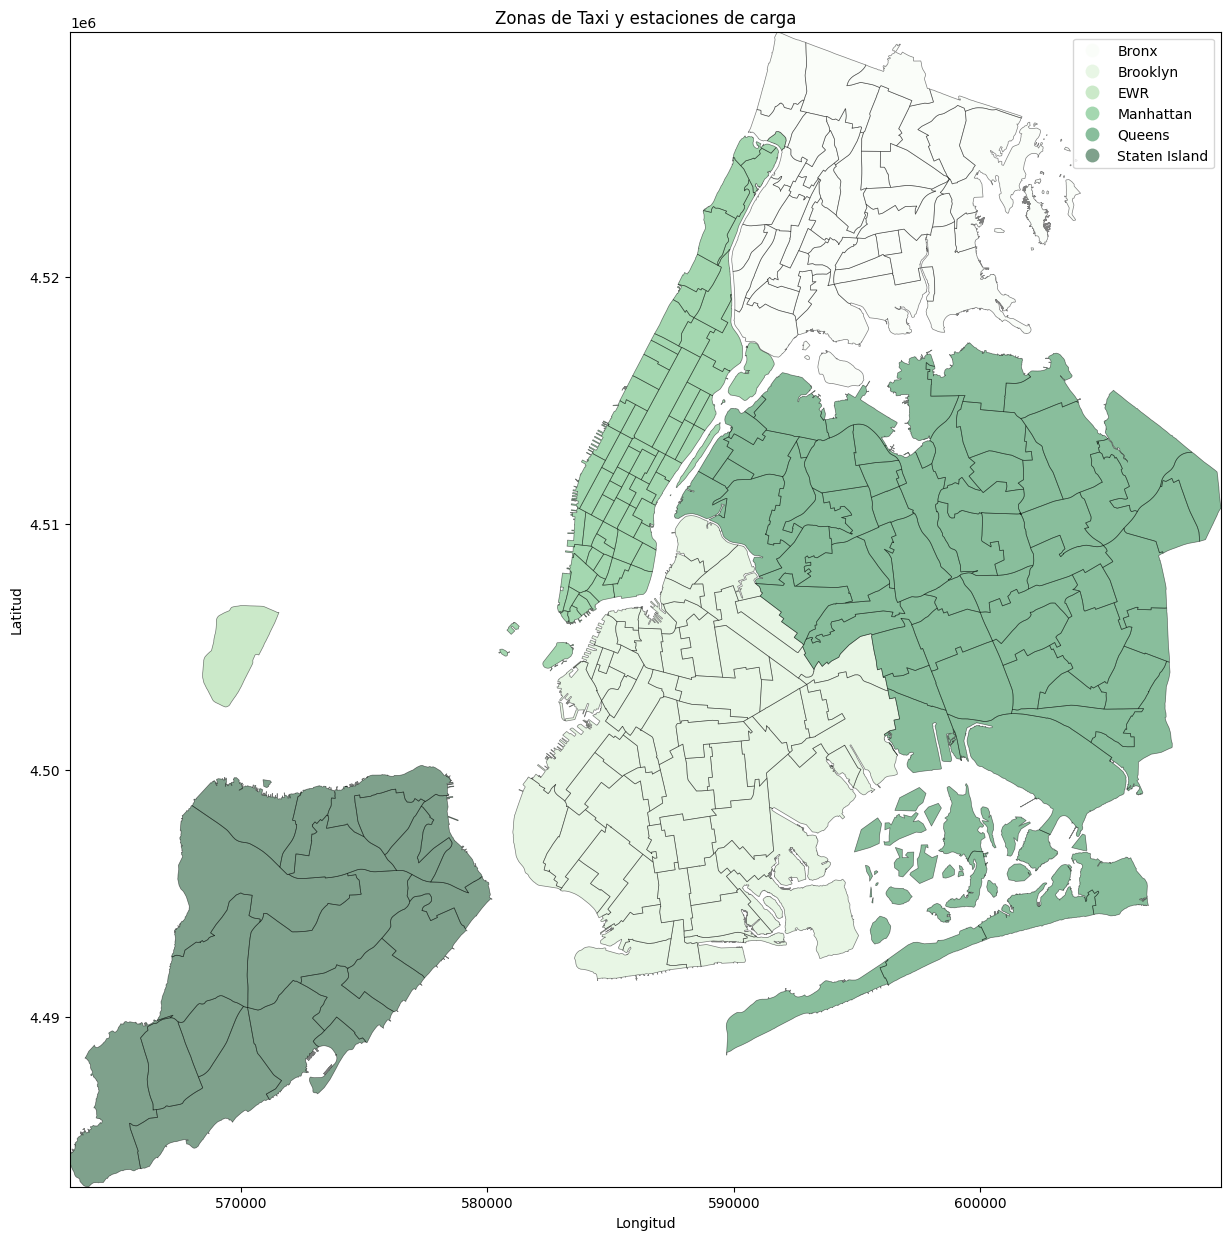

In [67]:
# Crea la grafica
fig, ax = plt.subplots(figsize=(25, 15))

# Grafica los poligonos
NYC_TAXI_ZONES_gdf.plot(ax=ax, column='borough', legend=True, alpha=0.5, edgecolor='black', linewidth=0.5, cmap='Greens')

charging_stations_gdf.plot(ax=ax, marker='o', color='red', markersize=20)

xmin, ymin, xmax, ymax = NYC_TAXI_ZONES_gdf.total_bounds

# Establece el limite de los ejes
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Titulo
ax.set_title('Zonas de Taxi y estaciones de carga')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Display plot
plt.show()


323
Street Address
11 E Loop Rd         8
10 Riverside Blvd    7
10 Central Rd        3
200 Chambers St      2
225 W 49th St        2
                    ..
300  E 74th St       1
300 E 59th St        1
300  E 54th St       1
30 W 63rd St         1
107 Essx St          1
Name: count, Length: 323, dtype: int64


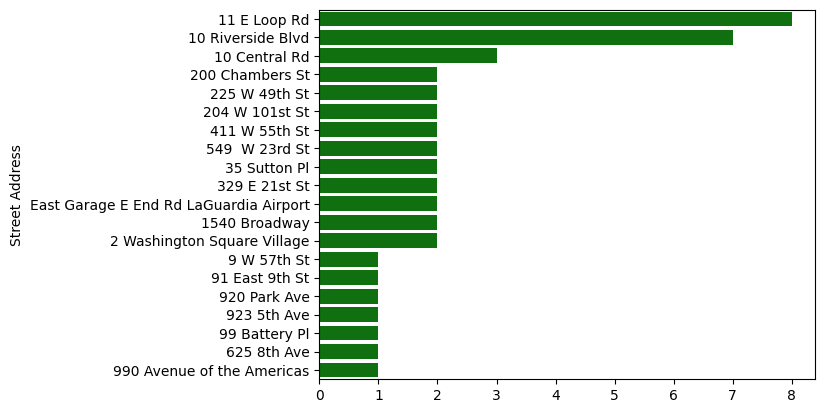

In [68]:

print(len(charging_stations_gdf['Street Address'].unique()))
print(charging_stations_gdf['Street Address'].value_counts())
top_5 = charging_stations_gdf['Street Address'].value_counts().head(20)
# Se crea un gráfico de barras
ax = sns.barplot(x=top_5.values, y=top_5.index, orient='y',color='Green')

# Se imprime la gráfica
plt.show()

EDA NYC_TAXI_ZONES

In [69]:
NYC_TAXI_ZONES_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   location_id  263 non-null    object  
 1   zone         263 non-null    object  
 2   borough      263 non-null    object  
 3   geometry     263 non-null    geometry
 4   centroid     263 non-null    object  
 5   centroid_x   263 non-null    float64 
 6   centroid_y   263 non-null    float64 
dtypes: float64(2), geometry(1), object(4)
memory usage: 14.5+ KB


In [78]:
duplicados=NYC_TAXI_ZONES_gdf.duplicated()
print(NYC_TAXI_ZONES_gdf[duplicados])

Empty GeoDataFrame
Columns: [location_id, zone, borough, geometry, centroid, centroid_x, centroid_y]
Index: []


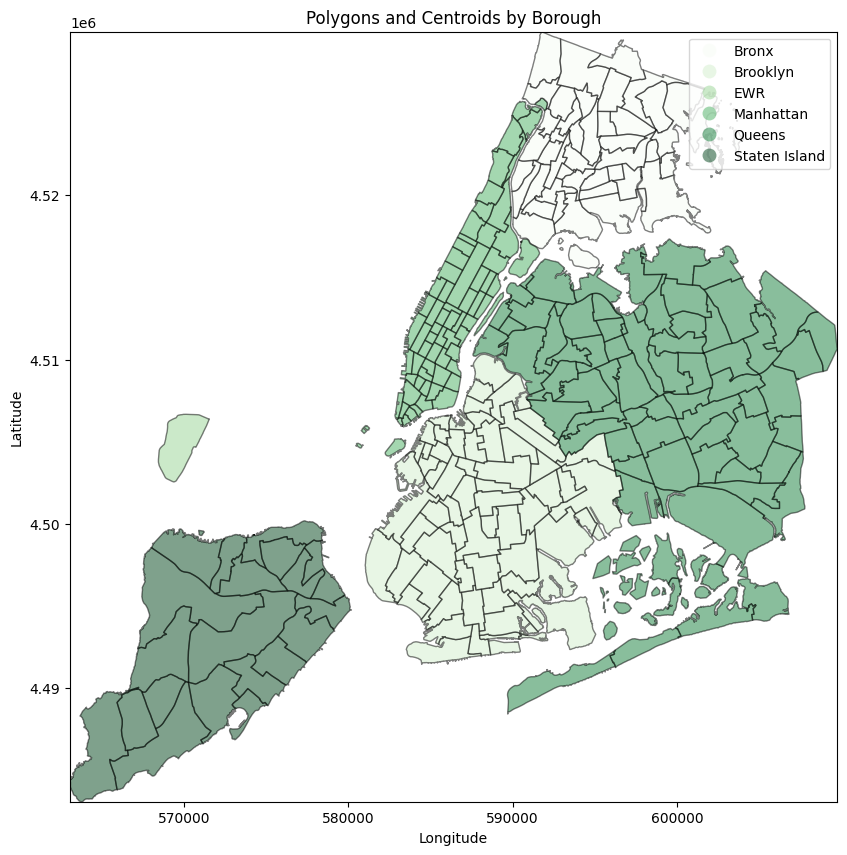

In [70]:

fig, ax = plt.subplots(figsize=(10, 10))
NYC_TAXI_ZONES_gdf.plot(ax=ax, column='borough', legend=True, edgecolor='black', alpha=0.5, cmap='Greens')

NYC_TAXI_ZONES_gdf.set_geometry('centroid').plot(ax=ax, color='red', markersize=5)

xmin, ymin, xmax, ymax = NYC_TAXI_ZONES_gdf.total_bounds

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.title('Polygons and Centroids by Borough')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

260
zone
Governor's Island/Ellis Island/Liberty Island    3
Corona                                           2
Newark Airport                                   1
Oakland Gardens                                  1
Park Slope                                       1
Name: count, dtype: int64


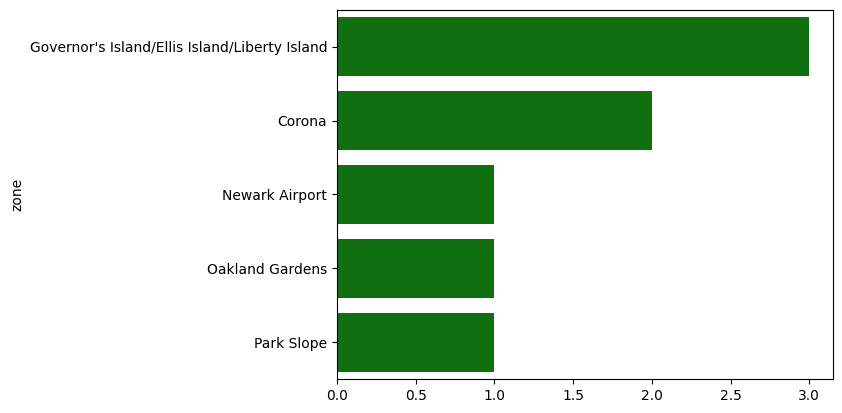

In [71]:
#Zone
print(len(NYC_TAXI_ZONES_gdf['zone'].unique()))

top_5 = NYC_TAXI_ZONES_gdf['zone'].value_counts().head(5)
print(top_5)
# Se crea un gráfico de barras
ax = sns.barplot(x=top_5.values, y=top_5.index, orient='y',color='Green')

# Se imprime la gráfica
plt.show()

6
borough
Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
EWR               1
Name: count, dtype: int64


/var/folders/0p/l9p40s5527102cq821lz6jlw0000gn/T/ipykernel_2152/2031553833.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


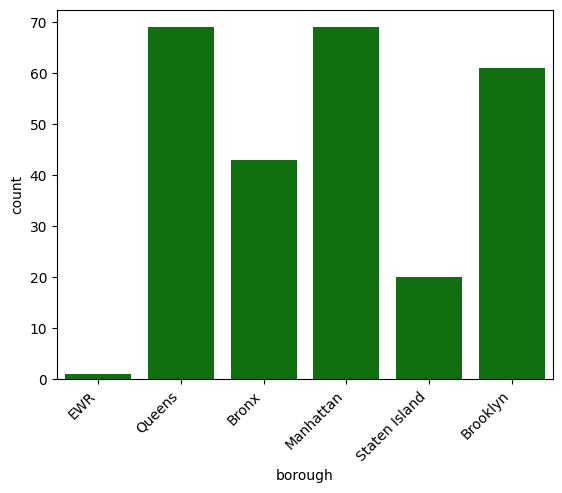

In [72]:
#Variables categoricas
#Borough
print(len(NYC_TAXI_ZONES_gdf['borough'].unique()))
print(NYC_TAXI_ZONES_gdf['borough'].value_counts())
ax = sns.countplot(x="borough", data=NYC_TAXI_ZONES_gdf,color='Green')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

EDA Trip_Data

In [73]:
Trip_Data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   trip_distance          float64       
 4   PULocationID           int64         
 5   DOLocationID           int64         
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 140.4 MB


In [80]:
duplicados=Trip_Data_df.duplicated()
print(Trip_Data_df[duplicados])

         VendorID tpep_pickup_datetime tpep_dropoff_datetime  trip_distance  \
133             2  2023-01-01 00:28:29   2023-01-01 00:31:03           0.42   
264             2  2023-01-01 00:20:18   2023-01-01 00:27:56           1.19   
325             2  2023-01-01 00:52:22   2023-01-01 01:14:03           4.89   
621             2  2023-01-01 00:06:39   2023-01-01 00:10:02           0.52   
924             2  2023-01-01 00:34:39   2023-01-01 00:40:25           0.85   
...           ...                  ...                   ...            ...   
2994679         2  2023-01-31 23:26:23   2023-01-31 23:56:00          14.02   
2994739         2  2023-01-31 23:58:56   2023-01-31 23:58:59           0.00   
2994909         2  2023-01-31 23:27:31   2023-01-31 23:58:16           8.33   
2994912         2  2023-01-31 23:06:10   2023-01-31 23:57:59          17.94   
2994935         2  2023-01-31 23:43:34   2023-02-01 00:17:53           6.02   

         PULocationID  DOLocationID  
133          

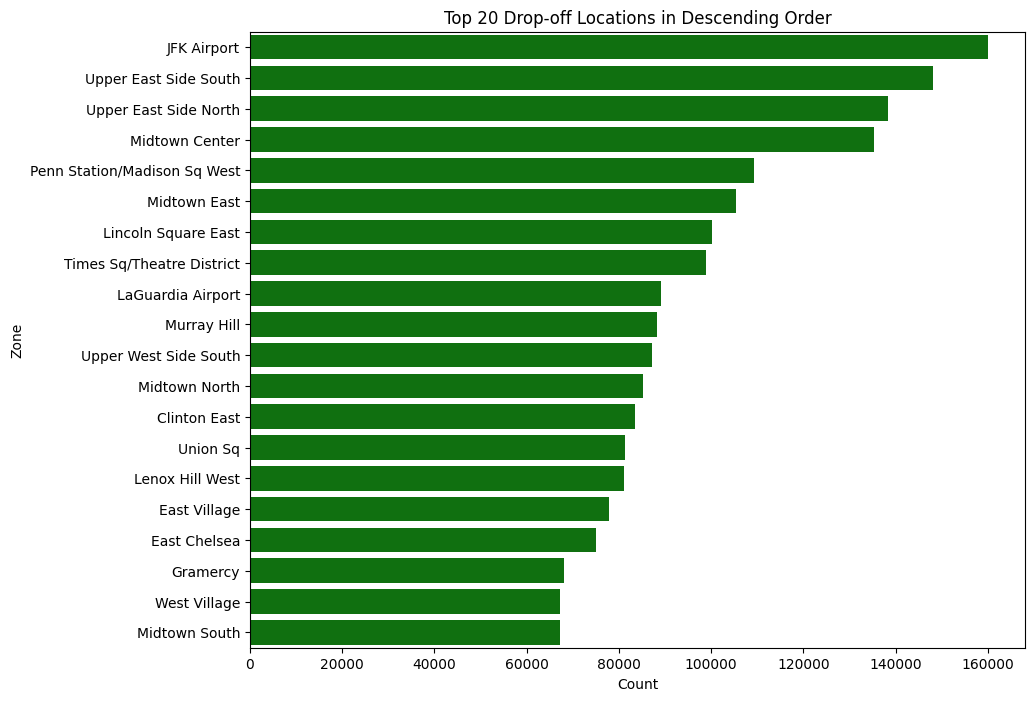

In [74]:

NYC_TAXI_ZONES_gdf['location_id'] = NYC_TAXI_ZONES_gdf['location_id'].astype(int)

merged_df = Trip_Data_df.merge(NYC_TAXI_ZONES_gdf, left_on='PULocationID', right_on='location_id')

location_counts = merged_df['PULocationID'].value_counts()

top_20 = location_counts.head(20)

top_20_zones = merged_df[merged_df['PULocationID'].isin(top_20.index)].drop_duplicates('PULocationID')[['PULocationID', 'zone']]

top_20_zones = top_20_zones.set_index('PULocationID')['zone']
top_20_sorted = top_20.rename(index=top_20_zones).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=top_20_sorted.values, y=top_20_sorted.index, orient='h', order=top_20_sorted.index, color='Green')

ax.set_xlabel('Count')
ax.set_ylabel('Zone')
ax.set_title('Top 20 Drop-off Locations in Descending Order')

plt.show()

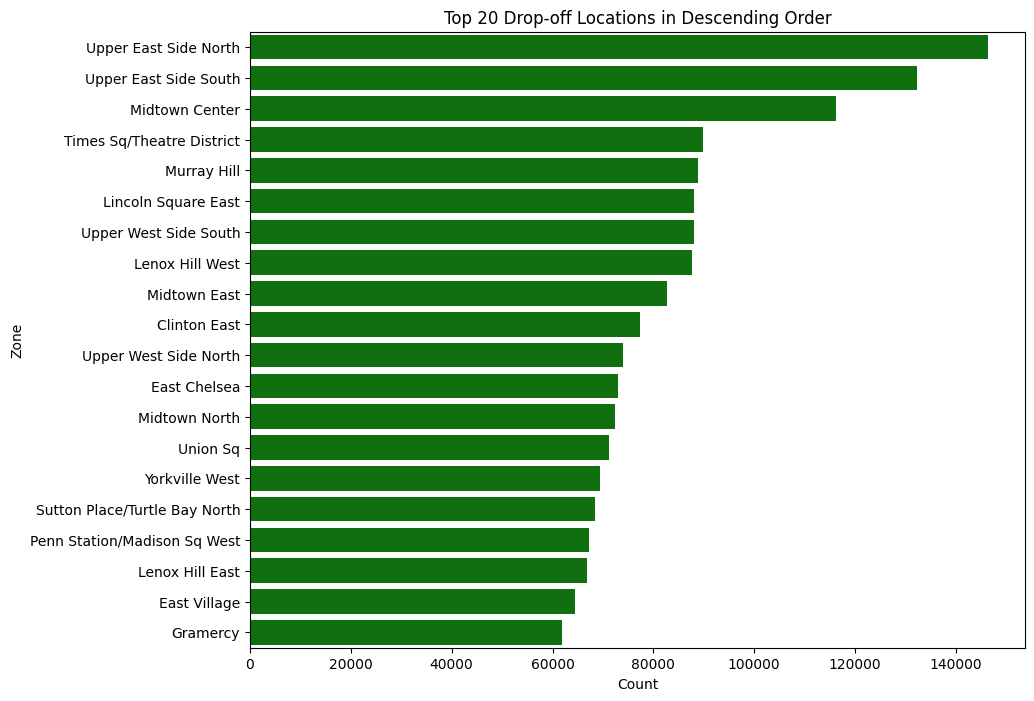

In [75]:
NYC_TAXI_ZONES_gdf['location_id'] = NYC_TAXI_ZONES_gdf['location_id'].astype(int)

merged_df = Trip_Data_df.merge(NYC_TAXI_ZONES_gdf, left_on='DOLocationID', right_on='location_id')

location_counts = merged_df['DOLocationID'].value_counts()

top_20 = location_counts.head(20)

top_20_zones = merged_df[merged_df['DOLocationID'].isin(top_20.index)].drop_duplicates('DOLocationID')[['DOLocationID', 'zone']]

top_20_zones = top_20_zones.set_index('DOLocationID')['zone']
top_20_sorted = top_20.rename(index=top_20_zones).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=top_20_sorted.values, y=top_20_sorted.index, orient='h', order=top_20_sorted.index, color='Green')

ax.set_xlabel('Count')
ax.set_ylabel('Zone')
ax.set_title('Top 20 Drop-off Locations in Descending Order')

plt.show()

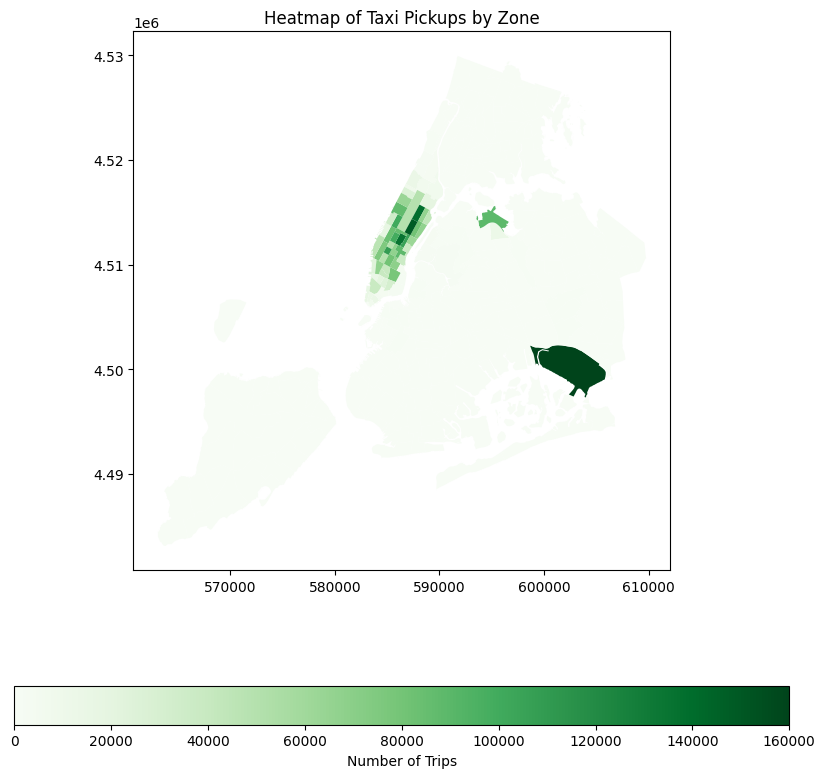

In [76]:
#Mapa de calor para el lugar de partida de los viajes

NYC_TAXI_ZONES_gdf['location_id'] = NYC_TAXI_ZONES_gdf['location_id'].astype(int)

merged_df = Trip_Data_df.merge(NYC_TAXI_ZONES_gdf, left_on='PULocationID', right_on='location_id')

zone_counts = merged_df.groupby('zone').size().reset_index(name='trip_count')

heatmap_data = NYC_TAXI_ZONES_gdf.merge(zone_counts, on='zone', how='left').fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
heatmap_data.plot(column='trip_count', cmap='Greens', ax=ax, legend=True,
                  legend_kwds={'label': "Number of Trips",
                               'orientation': "horizontal"})
plt.title('Heatmap of Taxi Pickups by Zone')
plt.show()


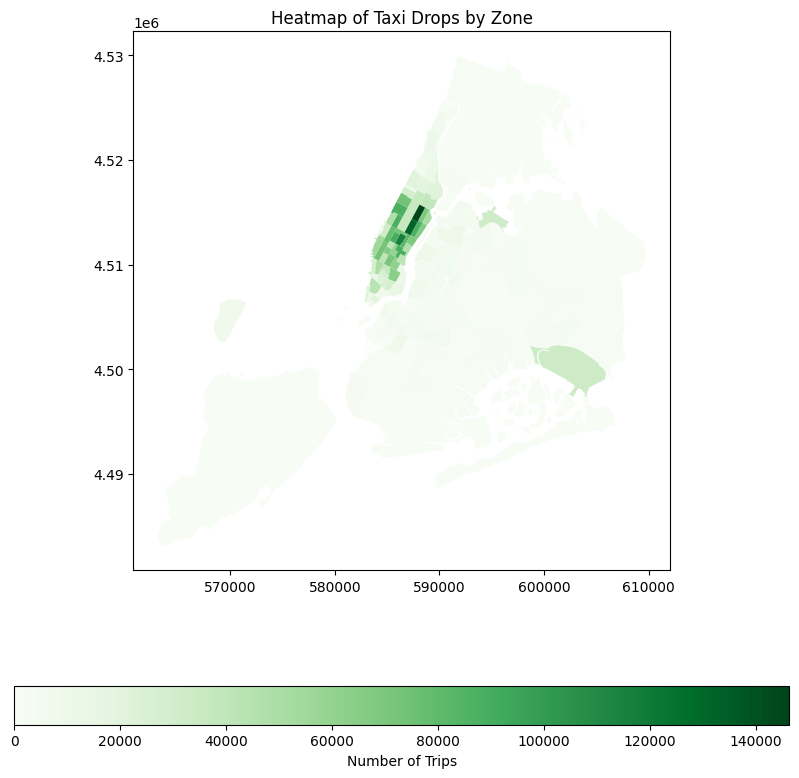

In [77]:
#Mapa de calor para el lugar de llegada de los viajes


NYC_TAXI_ZONES_gdf['location_id'] = NYC_TAXI_ZONES_gdf['location_id'].astype(int)

merged_df = Trip_Data_df.merge(NYC_TAXI_ZONES_gdf, left_on='DOLocationID', right_on='location_id')

zone_counts = merged_df.groupby('zone').size().reset_index(name='trip_count')

heatmap_data = NYC_TAXI_ZONES_gdf.merge(zone_counts, on='zone', how='left').fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
heatmap_data.plot(column='trip_count', cmap='Greens', ax=ax, legend=True,
                  legend_kwds={'label': "Number of Trips",
                               'orientation': "horizontal"})
plt.title('Heatmap of Taxi Drops by Zone')
plt.show()